In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [8]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [9]:
torch.manual_seed(1337)
batch_size = 4 # how many independant sequences will be processed in parallel?
block_size  = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        #each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx and targets are both (B, T) tensor if integers
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            #focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


In [11]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [12]:
batch_size = 32
for steps in range(1000):

    # sample a batch of data
    xb, yb = get_batch('train')

    #evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

3.721843719482422


In [13]:
print(decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


olylvLLko'TMyatyIoconxad.?-tNSqYPsx&bF.oiR;BD$dZBMZv'K f bRSmIKptRPly:AUC&$zLK,qUEy&Ay;ZxjKVhmrdagC-


In [22]:
torch.manual_seed(1337)
B,T,C = 4,8,32 #batch, time, channels
x = torch.randn(B,T,C)

# lets see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-1,-2)# (B, T, T)


tril = torch.tril(torch.ones((T,T)))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1)
v = value(x) # (B, T, 16)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

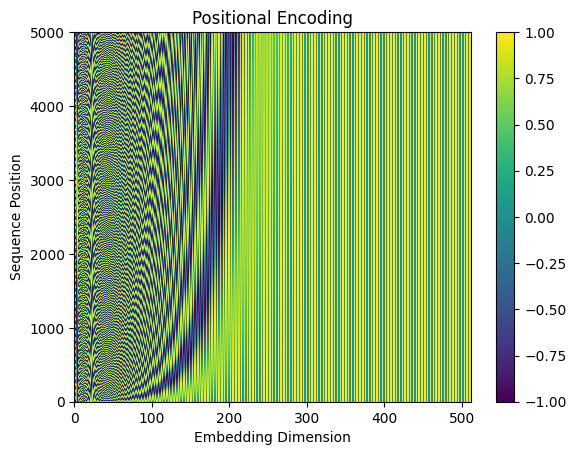

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_positional_encoding(max_seq_len, d_model):
    """
    Compute positional encoding for a particular position.
    
    Args:
    max_seq_len: int, maximum length of the sequence.
    d_model: int, depth of the model or embedding dimension.
    
    Returns:
    pos_encoding: numpy array, shape (max_seq_len, d_model), positional encoding.
    """
    pos_encoding = np.zeros((max_seq_len, d_model))
    positions = np.arange(max_seq_len)[:, np.newaxis]
    div_term = np.exp(-2 * np.arange(0., d_model, 2) * np.log(10000.0) / d_model)
    
    pos_encoding[:, 0::2] = np.sin(positions * div_term)
    pos_encoding[:, 1::2] = np.cos(positions * div_term)
    
    return pos_encoding

# Example Usage
max_seq_len = 5000  # max length of sequence
d_model = 512  # model depth / embedding dimension

pos_encoding = get_positional_encoding(max_seq_len, d_model)

# Optional: Visualization
plt.pcolormesh(pos_encoding, cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Sequence Position')
plt.colorbar()
plt.title('Positional Encoding')
plt.show()